# Machine Learning I
# Aprendizado Supervisionado
## Escrito por Duncan Ruiz

Prática com Decision Tree Classifier e velha

In [1]:
# pacotes básicos
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pacotes do sklearn para acesso a datasets, preparação, modelagem e avaliação
from sklearn import datasets
# pacote pipeline para combinar preparação e modelagem
from sklearn.pipeline import Pipeline, make_pipeline
# arsenal de preparação
from sklearn.preprocessing import MinMaxScaler # rescala em min-max
from sklearn.preprocessing import StandardScaler # padroniza features removendo média e
#     escalando para variância unitária. Também chamado de z-score
#
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold as skf
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree, export_graphviz, export_text
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as CMD

#pacotes para apoio a leitura e gravação de datasets
from pathlib import Path
import csv

#pacotes para visualização e formatação
import pprint
import graphviz

In [4]:
# carga de dados]
velha = pd.read_csv('amostras_.csv',sep = ';')

In [9]:
# separação em features e target
X = velha.drop(columns=['classe'])
y = velha['classe']

In [10]:
print(X.shape)
print(y.shape)

(231, 9)
(231,)


In [11]:
# separação em treino e teste, e X e y

treino_X, teste_X, treino_y, teste_y = tts(X, y, random_state=0,test_size=0.3, stratify=y)

print(treino_X.shape)
print(treino_y.shape)
print(teste_X.shape)
print(teste_y.shape)
print(np.stack(np.unique(teste_y, return_counts=True), axis=1))

(161, 9)
(161,)
(70, 9)
(70,)
[['Em_jogo' 25]
 ['Fim_de_jogo' 20]
 ['Possibilidade_de_fim_de_jogo' 25]]


In [12]:
teste_X

,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9
202,0,1,-1,1,0,0,0,-1,0
127,0,1,-1,1,-1,-1,1,0,1
16,1,-1,1,-1,1,0,-1,1,-1
137,0,1,-1,1,-1,0,-1,1,0
192,-1,1,-1,1,1,0,-1,1,0
...,...,...,...,...,...,...,...,...,...
57,1,-1,1,-1,0,0,1,-1,1
109,-1,1,-1,1,-1,1,-1,0,1
41,1,-1,1,-1,0,1,0,-1,1
152,0,1,-1,1,0,-1,1,0,-1


In [45]:
# indução do modelo de classificação por árvore de decisão
#ccp_alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
#ccp_alphas = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
#ccp_alphas = [0.055]
ccp_alphas = [0.0]

for ccp_i in ccp_alphas:
    modelo = DTC(random_state=0
                ,criterion='log_loss'  # 'gini', 'entropy', 'log_loss'
                ,min_samples_split=2  # default 2
                ,min_samples_leaf=1   # default 1
                ,max_leaf_nodes=None  # default None
                ,class_weight=None    # default None. 'balanced' para equilibrar classes
                ,ccp_alpha=ccp_i        # default 0.0 Valores na documentação 0.005 0.01 0.015 0.02 0.025 0.03 0.035
                )
    modelo.fit(treino_X, treino_y)
    teste_pred_y = modelo.predict(teste_X)
    acuracia = acc_score(teste_y, teste_pred_y)
    resultado = cm(teste_y, teste_pred_y)

    #cm_display = CMD(resultado).plot()
    print('Alpha=', ccp_i,' Acuracia=', acuracia)


Alpha= 0.0  Acuracia= 0.45714285714285713


In [46]:
# apresentações do modelo
modelo_txt = export_text(modelo, feature_names=velha.drop(columns=['classe']).columns)
print(modelo_txt)

|--- pos7 <= -0.50
|   |--- pos5 <= -0.50
|   |   |--- pos2 <= 0.00
|   |   |   |--- pos6 <= 0.50
|   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |--- pos6 >  0.50
|   |   |   |   |--- pos9 <= 0.50
|   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |--- pos9 >  0.50
|   |   |   |   |   |--- class: Fim_de_jogo
|   |   |--- pos2 >  0.00
|   |   |   |--- class: Fim_de_jogo
|   |--- pos5 >  -0.50
|   |   |--- pos5 <= 0.50
|   |   |   |--- pos6 <= 0.50
|   |   |   |   |--- pos8 <= 0.50
|   |   |   |   |   |--- class: Em_jogo
|   |   |   |   |--- pos8 >  0.50
|   |   |   |   |   |--- pos1 <= 0.50
|   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |   |--- pos1 >  0.50
|   |   |   |   |   |   |--- pos6 <= -0.50
|   |   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |   |   |--- pos6 >  -0.50
|   |   |   |   |   |   |   |--- class: Em_jogo
|   |   |   |--- pos6 >  0.50
|   |   |   |   |--

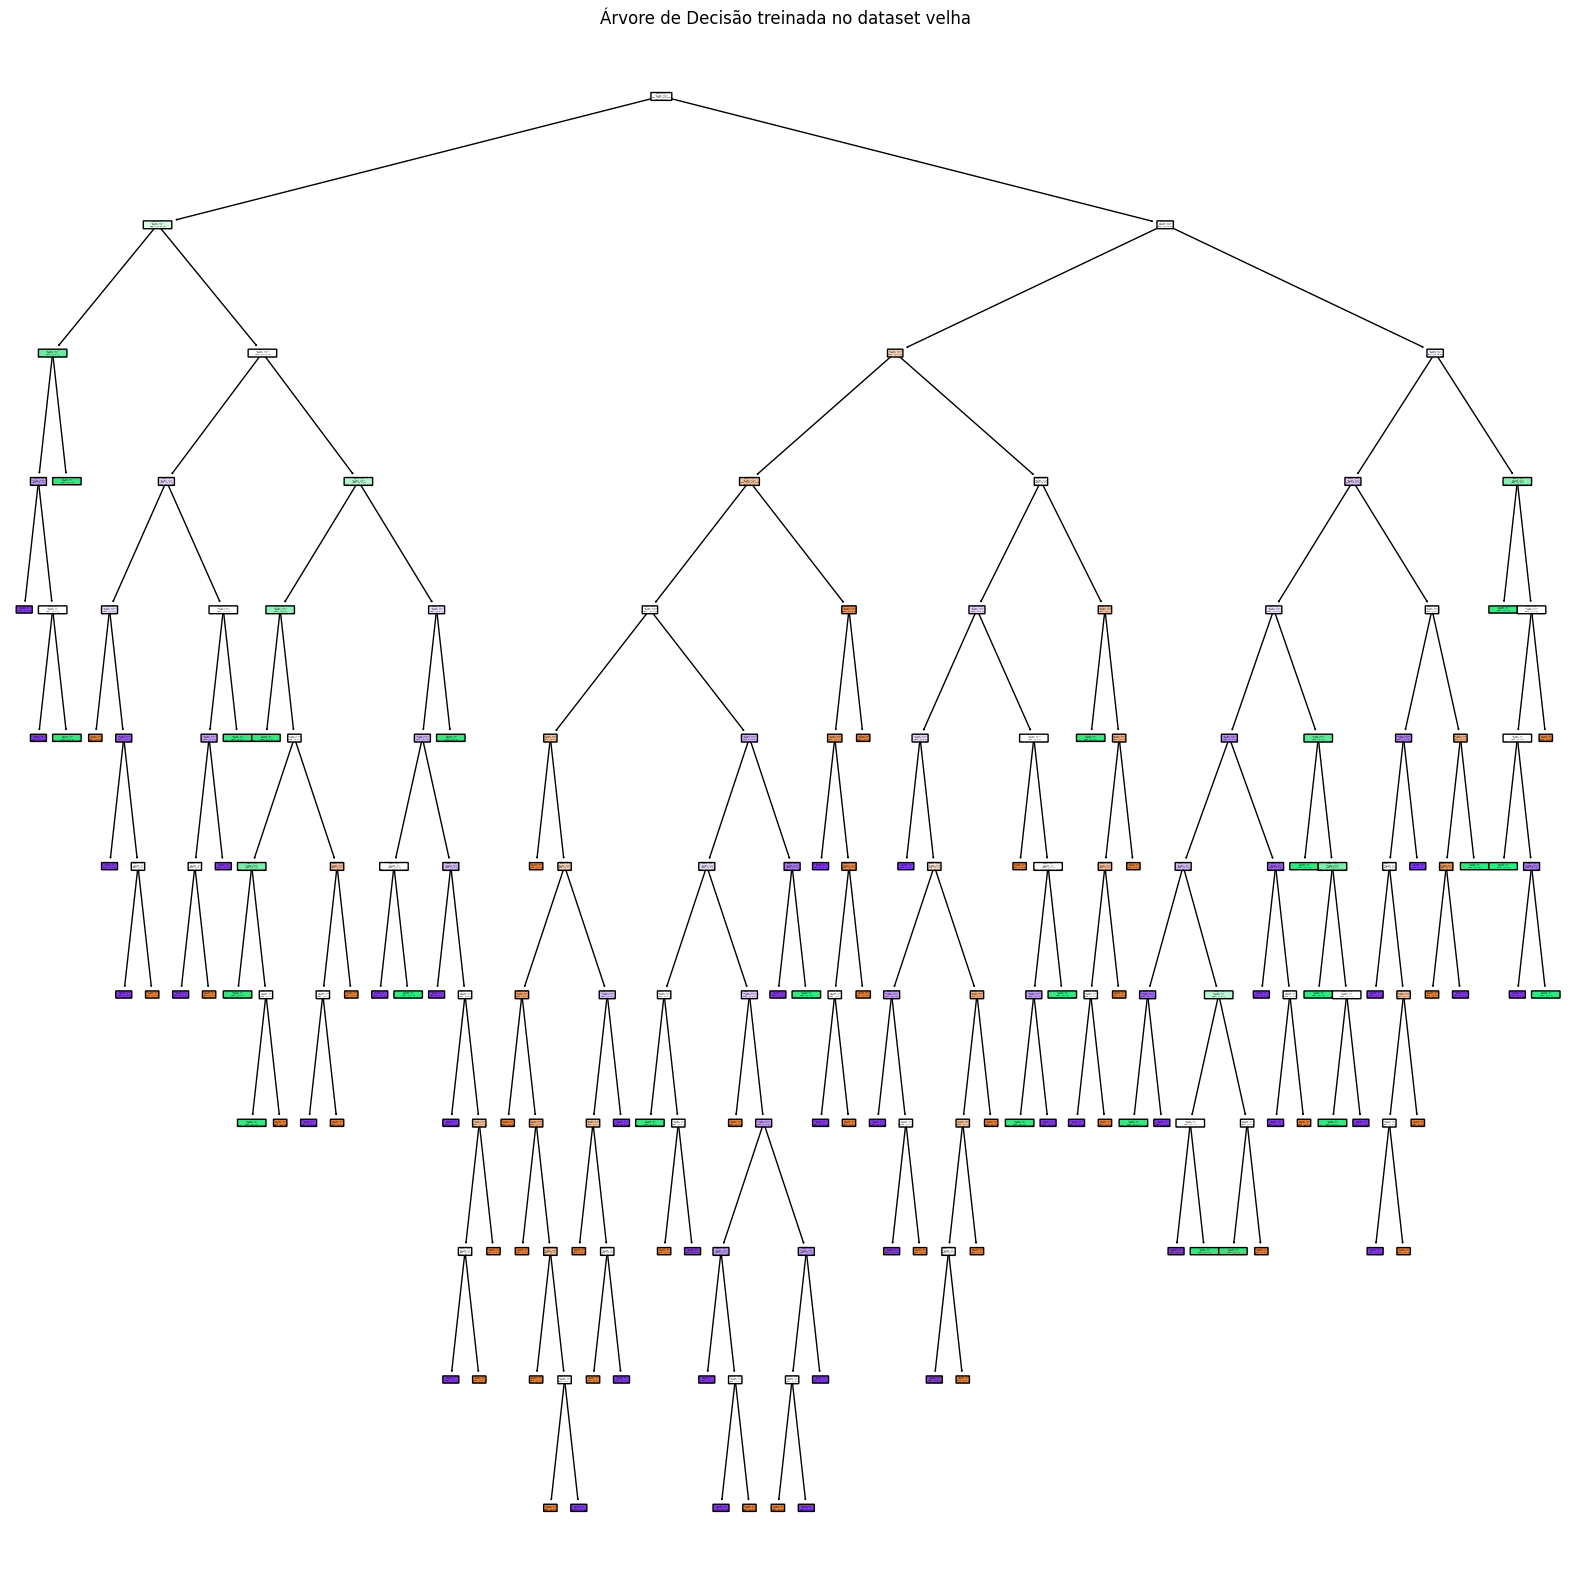

In [49]:
# apresentações do modelo
plt.figure(figsize=(20, 20))
plot_tree(modelo, filled=True, rounded=True, feature_names=velha.drop(columns=['classe']).columns, class_names=['Em_jogo','Possibilidade_de_fim_de_jogo','Fim_de_jogo'])
plt.title('Árvore de Decisão treinada no dataset velha')
plt.show()
